# About: Hadoop Swimlanes - Ready! on Tez

----

Tezがインストールされた環境にtez-toolsをインストールし、Swimlanesを使用できるようにします。

## *Operation Note*

*This is a cell for your own recording. ここに経緯を記述*

# 操作対象クラスタの設定

起動したい対象のクラスタ名を設定する。

In [1]:
target_group = 'hadoop_all_testcluster'

対象クラスタにAnsibleでpingできることを確認する。

In [2]:
!ansible -m ping {target_group}

XXX.XXX.XXX.72 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}
XXX.XXX.XXX.73 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}
XXX.XXX.XXX.112 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}
XXX.XXX.XXX.70 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}
XXX.XXX.XXX.71 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}
XXX.XXX.XXX.113 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}
XXX.XXX.XXX.114 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}


インストール対象は、 `hadoop_swimlane` というグループに所属しているものとする。

In [3]:
!ansible -m ping hadoop_swimlane -l {target_group}

XXX.XXX.XXX.72 | SUCCESS => {
    "changed": false, 
    "ping": "pong"
}


# 設定の定義

インストール対象パスなど、設定を定義する。

In [4]:
swimlane_install_path = '/usr/local/lib'
swimlane_tmp_path = '/tmp'

インストールするtez-toolsのバージョンを定義する。gitからcloneしてくるためのtagも定義しておく。

https://github.com/apache/tez

In [6]:
swimlane_tez_version = '0.8.4'
swimlane_tez_repo_tag = 'rel/release-' + swimlane_tez_version

Playbookなど定義するための一時ディレクトリを定義しておく。

In [27]:
import os
import tempfile

work_dir = tempfile.mkdtemp()
work_dir

'/tmp/tmpSixtFf'

# tez-toolsのインストール

Gitからcloneしてくる・・・まずは対象ホストにgitをインストールする。

In [9]:
!ansible -b -m yum -a 'name=git state=latest' hadoop_swimlane -l {target_group}

XXX.XXX.XXX.72 | SUCCESS => {
    "changed": true, 
    "msg": "", 
    "rc": 0, 
    "results": [
        "Loaded plugins: fastestmirror\nSetting up Install Process\nLoading mirror speeds from cached hostfile\n * base: ftp.iij.ad.jp\n * extras: ftp.iij.ad.jp\n * updates: ftp.iij.ad.jp\nResolving Dependencies\n--> Running transaction check\n---> Package git.x86_64 0:1.7.1-4.el6_7.1 will be installed\n--> Processing Dependency: perl-Git = 1.7.1-4.el6_7.1 for package: git-1.7.1-4.el6_7.1.x86_64\n--> Processing Dependency: rsync for package: git-1.7.1-4.el6_7.1.x86_64\n--> Processing Dependency: perl(Git) for package: git-1.7.1-4.el6_7.1.x86_64\n--> Processing Dependency: perl(Error) for package: git-1.7.1-4.el6_7.1.x86_64\n--> Running transaction check\n---> Package perl-Error.noarch 1:0.17015-4.el6 will be installed\n---> Package perl-Git.noarch 0:1.7.1-4.el6_7.1 will be installed\n---> Package rsync.x86_64 0:3.0.6-12.el6 will be installed\n--> Finished Dependency Resolution\n\nDependen

リポジトリからcloneしてくる。

In [11]:
!ansible -b -m git -a 'repo=https://github.com/apache/tez.git dest={ swimlane_install_path }/apache-tez-{ swimlane_tez_version }-src version={ swimlane_tez_repo_tag }' \
         hadoop_swimlane -l {target_group}

XXX.XXX.XXX.72 | SUCCESS => {
    "after": "ef70407682918c022dffea86d6fa0571ccebcd8b", 
    "before": null, 
    "changed": true
}


yarnユーザで実行することを想定して、ディレクトリのOwner, Permissionを調整しておく。

In [12]:
!ansible -b -m file -a 'path={ swimlane_install_path }/apache-tez-{ swimlane_tez_version }-src/tez-tools/swimlanes state=directory mode=777 owner=yarn group=hadoop' \
         hadoop_swimlane -l {target_group}

XXX.XXX.XXX.72 | SUCCESS => {
    "changed": true, 
    "gid": 496, 
    "group": "hadoop", 
    "mode": "0777", 
    "owner": "yarn", 
    "path": "/usr/local/lib/apache-tez-0.8.4-src/tez-tools/swimlanes", 
    "size": 4096, 
    "state": "directory", 
    "uid": 496
}


`yarn-swimlanes.sh` が作成されていることを確認する。

In [16]:
!ansible -a 'ls -la { swimlane_install_path }/apache-tez-{ swimlane_tez_version }-src/tez-tools/swimlanes/yarn-swimlanes.sh' \
         hadoop_swimlane -l {target_group}

XXX.XXX.XXX.72 | SUCCESS | rc=0 >>
-rw-r--r-- 1 root root 980 Aug 19 10:21 /usr/local/lib/apache-tez-0.8.4-src/tez-tools/swimlanes/yarn-swimlanes.sh



# group_varsパラメータの更新

このクラスタのgroup_varsにSwimlane関連のパラメータを追加しておく。いったん現在のgroup_varsをバックアップしておく。

In [18]:
!cp group_vars/{target_group} {work_dir}/group_vars-old

[group_vars](../tree/group_vars) ディレクトリ中の `group_vars/hadoop_all_{{クラスタ名}}` に以下を追記する。

In [23]:
import yaml
swimlane_vars = {'swimlane_install_path': swimlane_install_path, 'swimlane_tmp_path': swimlane_tmp_path,
                 'swimlane_tez_version': swimlane_tez_version}
print('# Swimlane\n' + yaml.dump(swimlane_vars, default_flow_style=False))

# Swimlane
swimlane_install_path: /usr/local/lib
swimlane_tez_version: 0.8.4
swimlane_tmp_path: /tmp



In [24]:
!diff -u {work_dir}/group_vars-old group_vars/{target_group}

--- /tmp/tmpBi2ROi/group_vars-old	2016-08-19 10:27:23.854033715 +0900
+++ group_vars/hadoop_all_testcluster	2016-08-19 10:32:01.916381623 +0900
@@ -47,8 +47,6 @@
 # Java
 jdk7_downloadurl: 'http://xxx.xxx.nii.ac.jp:YYYY/v1/AUTH_XXXXXXXXXXXXXXXXXXXXXXXX/HDP-2.x/archive'
 jdk8_downloadurl: 'http://xxx.xxx.nii.ac.jp:YYYY/v1/AUTH_XXXXXXXXXXXXXXXXXXXXXXXX/HDP-2.x/archive'
-# Swimlane
-swimlane_tez_version: '0.8.4'
 
 # HDFS
 dfs_namenode_name_dirs:
@@ -80,3 +78,9 @@
 # Spark
 spark_download_url: 'http://xxx.xxx.nii.ac.jp:YYYY/v1/AUTH_XXXXXXXXXXXXXXXXXXXXXXXX/HDP-2.x/archive'
 spark_history_server_host: 'testvm003'
+
+# Swimlane
+swimlane_install_path: /usr/local/lib
+swimlane_tez_version: 0.8.4
+swimlane_tmp_path: /tmp
+


# 動作確認

YARNでサンプルジョブを実行してみて、Swimlaneの出力が得られるかを確認する。

In [29]:
yarn_result = os.path.join(work_dir, 'yarn-result')
!ansible -a "yarn jar /usr/hdp/current/hadoop-mapreduce-client/hadoop-mapreduce-examples.jar pi 10 1000" -l { target_group } hadoop_client \
         | tee {yarn_result}

XXX.XXX.XXX.72 | SUCCESS | rc=0 >>
Number of Maps  = 10
Samples per Map = 1000
Wrote input for Map #0
Wrote input for Map #1
Wrote input for Map #2
Wrote input for Map #3
Wrote input for Map #4
Wrote input for Map #5
Wrote input for Map #6
Wrote input for Map #7
Wrote input for Map #8
Wrote input for Map #9
Starting Job
Job Finished in 25.773 seconds
Estimated value of Pi is 3.1408000000000000000016/08/19 10:49:35 INFO impl.TimelineClientImpl: Timeline service address: http://testvm003:8188/ws/v1/timeline/
16/08/19 10:49:36 INFO input.FileInputFormat: Total input paths to process : 10
16/08/19 10:49:36 INFO mapreduce.JobSubmitter: number of splits:10
16/08/19 10:49:37 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1471559811619_0004
16/08/19 10:49:37 INFO client.YARNRunner: Number of stages: 2
16/08/19 10:49:37 INFO client.TezClient: Tez Client Version: [ component=tez-api, version=XXX.XXX.XXX.2.4.2.0-258, revision=fa554fdce4e3495e09a310e0a32bb34ccc5946ad, SCM-URL=scm:git:

Swimlane実行用Playbookを準備する。

In [30]:
%%writefile {work_dir}/swimlane.yml
- hosts: hadoop_swimlane
  tasks:
    - name: delete_swimlane_old_output
      become: yes
      file: path={{ swimlane_install_path }}/apache-tez-{{ swimlane_tez_version }}-src/tez-tools/swimlanes/{{ yarn_application_id }}.svg state=absent
  
    - name: create_swimlane_analyze
      shell: bash yarn-swimlanes.sh {{ yarn_application_id }}
      args:
        chdir: "{{ swimlane_install_path }}/apache-tez-{{ swimlane_tez_version }}-src/tez-tools/swimlanes/"
  
    - name: download_svg
      fetch: src={{ swimlane_install_path }}/apache-tez-{{ swimlane_tez_version }}-src/tez-tools/swimlanes/{{ yarn_application_id }}.svg dest={{ local_svg_path }} flat=yes


Writing /tmp/tmpSixtFf/swimlane.yml


先に実行したpiの application Idを得ておく。

In [31]:
yarn_application_id = None
with open(yarn_result, 'r') as f:
    for line in f:
        if 'Submitting DAG application with id' in line:
            yarn_application_id = line.split()[-1]
assert(yarn_application_id is not None)
yarn_application_id

'application_1471559811619_0004'

swimlaneのスクリプトを実行し、SVGファイルをダウンロードする。

In [32]:
local_svg_path = os.path.join(work_dir, 'result.svg')
extra_vars = ['-e yarn_application_id={}'.format(yarn_application_id), '-e local_svg_path={}'.format(local_svg_path)]
!ansible-playbook {' '.join(extra_vars)} {work_dir}/swimlane.yml -l {target_group}


PLAY [hadoop_swimlane] *********************************************************

TASK [setup] *******************************************************************
ok: [XXX.XXX.XXX.72]

TASK [delete_swimlane_old_output] **********************************************
ok: [XXX.XXX.XXX.72]

TASK [create_swimlane_analyze] *************************************************
changed: [XXX.XXX.XXX.72]

TASK [download_svg] ************************************************************
changed: [XXX.XXX.XXX.72]

PLAY RECAP *********************************************************************
XXX.XXX.XXX.72               : ok=4    changed=2    unreachable=0    failed=0   



ダウンロードしたSVGファイルをレンダリングする。

(以下にSwimlanesの出力画像が表示されない場合、JupyterのFileメニューからTrust Notebookすることで出力画像が表示されるようになります。)

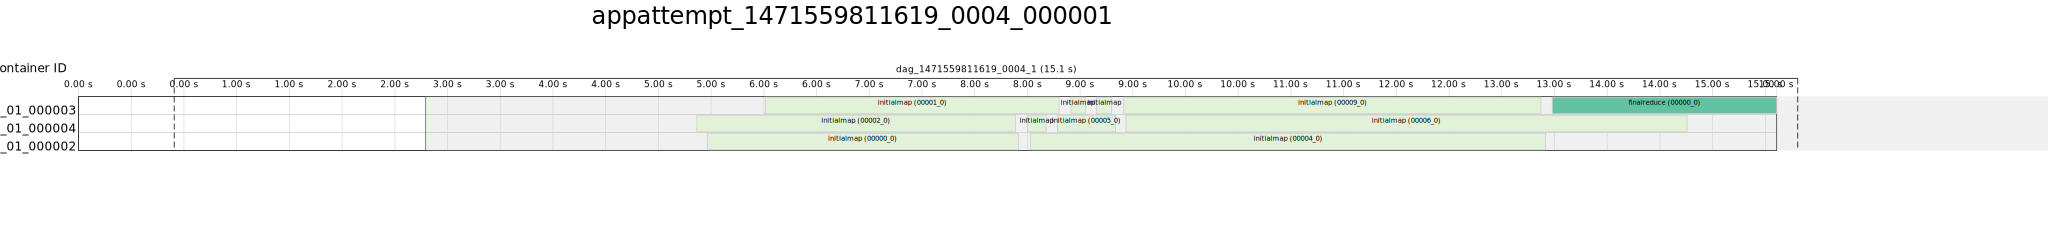

In [33]:
from IPython.display import SVG
SVG(filename=local_svg_path)

# 後始末

一時ディレクトリを削除する。

In [34]:
!rm -fr {work_dir}